# Homework 03 - Part 1 : Data Wrangling


_Goal_ :

**We want to build an interactive map visualization showing how much grant money goes to each Swiss canton. To do so, we have at our disposal a `.csv` file containing a list of grants with the corresponding amount and university. In order to build our map, we first have to get location data about the grants. That is, we want to know for each university in the dataset the corresponding swiss *canton*.**

_Tools_ :

**The tools used for this part are :**
* Pandas
* Requests
* BeautifoulSoup
* [Google Places Geocoding API](https://developers.google.com/maps/documentation/geocoding/intro).

_Contents_ :
* [1 - Data exploration](#1---Data-exploration)
* [2 - Mapping universities to cantons](#2---Mapping-universities-to-cantons)

---

First, we make some useful and usual imports. Mind that we also import from a custom file `helpers.py`.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from helpers import * # custom helper file

# 1 - Data exploration

## Importing grants data

The main file containing data about the grants is `P3_GrantExport.csv`. We use the `read_csv` function of *pandas* to create a DataFrame from this data. Mind that we have to specify that a custom separator `;` is used in this file.

In [3]:
grants = pd.read_csv('./SNSF_data/P3_GrantExport.csv',sep=';')
grants.head()

,Project Number,Project Title,Project Title English,Responsible Applicant,Funding Instrument,Funding Instrument Hierarchy,Institution,University,Discipline Number,Discipline Name,Discipline Name Hierarchy,Start Date,End Date,Approved Amount,Keywords
0,1,Schlussband (Bd. VI) der Jacob Burckhardt-Biog...,NaN,Kaegi Werner,Project funding (Div. I-III),Project funding,NaN,Nicht zuteilbar - NA,10302,Swiss history,Human and Social Sciences;Theology & religious...,01.10.1975,30.09.1976,11619.00,NaN
1,4,Batterie de tests à l'usage des enseignants po...,NaN,Massarenti Léonard,Project funding (Div. I-III),Project funding,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,10104,Educational science and Pedagogy,"Human and Social Sciences;Psychology, educatio...",01.10.1975,30.09.1976,41022.00,NaN
2,5,"Kritische Erstausgabe der ""Evidentiae contra D...",NaN,Kommission für das Corpus philosophorum medii ...,Project funding (Div. I-III),Project funding,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",10101,Philosophy,Human and Social Sciences;Linguistics and lite...,01.03.1976,28.02.1985,79732.00,NaN
3,6,Katalog der datierten Handschriften in der Sch...,NaN,Burckhardt Max,Project funding (Div. I-III),Project funding,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,10302,Swiss history,Human and Social Sciences;Theology & religious...,01.10.1975,30.09.1976,52627.00,NaN
4,7,Wissenschaftliche Mitarbeit am Thesaurus Lingu...,NaN,Schweiz. Thesauruskommission,Project funding (Div. I-III),Project funding,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",10303,Ancient history and Classical studies,Human and Social Sciences;Theology & religious...,01.01.1976,30.04.1978,120042.00,NaN


## A bit of data exploration

As usual, let us first look a bit at what we have. In particular, let's look at the distribution of the number of grants per university.

In [4]:
uni_grants_counts = grants.University.value_counts().value_counts()

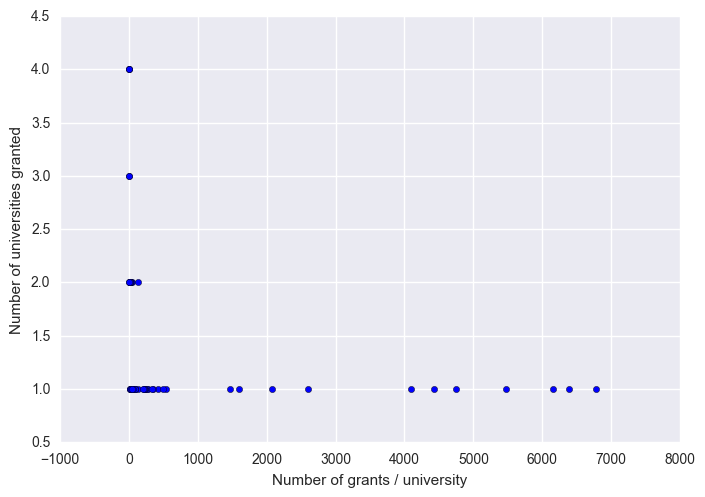

In [5]:
uni_grants_dist_scat = plt.scatter(uni_grants_counts.index, uni_grants_counts.values)
plt.xlabel('Number of grants / university')
plt.ylabel('Number of universities granted')

# 2 - Mapping universities to cantons

## The automatic part...

In fact, to build our map viz, we are mainly interested in the unique values (ie. names) of the column `University`. Let's retrieve this set of values in a `universities` variable. Then, we will have to find a mapping going from each unique value to a canton code. 

In [6]:
universities = grants.University.unique()
universities[:10]

array(['Nicht zuteilbar - NA', 'Université de Genève - GE',
       'NPO (Biblioth., Museen, Verwalt.) - NPO', 'Universität Basel - BS',
       'Université de Fribourg - FR', 'Universität Zürich - ZH',
       'Université de Lausanne - LA', 'Universität Bern - BE',
       'Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL',
       'Université de Neuchâtel - NE'], dtype=object)

After a quick Google search, we can find the list of the 26 swiss cantons codes in a `.csv` file [on this GitHub repository](https://github.com/d-qn/swiss-maps/blob/master/meta/cantons.csv). Let's use this file to build a list containing all the valid codes of swiss cantons. To do so, we use the `read_csv` function again and just retain the column containing the codes, transformed to a Python list.

In [7]:
cantons_df = pd.read_csv('cantons.csv')
cantons = list(cantons_df.canton.values)

Now, we have to actually find a canton code for each university. To (try to) do so, we use our helper function `build_df`, which is defined in the file `helpers.py`.

This function takes two parameters :
* the list of universities
* a list of valid codes

Then it tries to find the code for each university, by scraping the result page on Google to find an address (it is often displayed in the "card" right of the search results) and then find the associated canton with the [Google Places Geocoding API](https://developers.google.com/maps/documentation/geocoding/intro).

We store the results in a DataFrame `uni_cantons`.

In [8]:
uni_cantons = build_df(universities, cantons)

Searching for cantons... 78/78

Let's look at the universities for which we couldn't find a canton code, ie. those corresponding to `None` values in `uni_cantons`.

In [9]:
not_found = uni_cantons[pd.isnull(uni_cantons.canton)]
print("Not found : {}".format(len(not_found)))

Not found : 24


Unfortunately, there is almost 1/3 of the universities for which we don't have a result. According to the assignment rules, we can search them by hand. Let's print them, then.

In [10]:
not_found

,university,address,latitude,longitude,canton
0,Nicht zuteilbar - NA,NaN,NaN,NaN,NaN
2,"NPO (Biblioth., Museen, Verwalt.) - NPO",NaN,NaN,NaN,NaN
8,"Eidg. Forschungsanstalt für Wald,Schnee,Land -...",NaN,NaN,NaN,NaN
11,Inst. de Hautes Etudes Internat. et du Dév - I...,"Maison de la Paix, Chemin Eugène-Rigot 2, 1202...",46.220787,6.143574,NaN
13,Weitere Institute - FINST,NaN,NaN,NaN,NaN
14,Firmen/Privatwirtschaft - FP,NaN,NaN,NaN,NaN
26,Eidg. Material und Prüfungsanstalt - EMPA,NaN,NaN,NaN,NaN
27,Physikal.-Meteorolog. Observatorium Davos - PMOD,NaN,NaN,NaN,NaN
30,Weitere Spitäler - ASPIT,NaN,NaN,NaN,NaN
31,AO Research Institute - AORI,NaN,NaN,NaN,NaN


## ... and the manual one

After searching by hand, we can come up with cantons for almost every university.

In [11]:
manual_search = {
    'AO Research Institute - AORI': 'GR',                       # Davos, GR
    'Allergie- und Asthmaforschung - SIAF': 'GR',               # Davos, GR
    'Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL': 'ZH', # Birmensdorf, ZH
    'Eidg. Material und Prüfungsanstalt - EMPA': 'ZH',          # Dübendorf, ZH (also St Gallen & Thun...)
    'Fachhochschule Nordwestschweiz (ohne PH) - FHNW': 'SO',    # Olten, SO
    'Fernfachhochschule Schweiz (Mitglied SUPSI) - FFHS': 'VS', # Brig, VS
    'Forschungsinstitut für Opthalmologie - IRO': 'VS',         # Sion, VS
    'Forschungskommission SAGW': 'BE',                          # Bern, BE
    'Inst. de Hautes Etudes Internat. et du Dév - IHEID': 'GE', # Geneva, GE
    'Physikal.-Meteorolog. Observatorium Davos - PMOD': 'GR',   # Davos, GR
    'Pädagogische Hochschule Nordwestschweiz - PHFHNW': 'AG',   # Windisch, AG
    'Pädagogische Hochschule Wallis - PHVS': 'VS',              # Saint Maurice, VS
    'Schweizer Kompetenzzentrum Sozialwissensch. - FORS': 'VD', # Lausanne, VD
    'Staatsunabh. Theologische Hochschule Basel - STHB': 'BS',  # Basel, BS
    'Swiss Institute of Bioinformatics - SIB': 'VD'             # Lausanne, VD
    }


def get_canton_code(university, mappings):
    """Get the canton code given a university name and the university/canton dictionary.
    
    If the university is not in the dictionary, returns a NaN.
    """
    if university in mappings.keys() and mappings[university] is not None:
        return mappings[university]
    else:
        return np.nan


# Put manual results into the grants dataframe
for row in uni_cantons.index:
    if pd.isnull(uni_cantons.loc[row, 'canton']):
        uni_cantons.loc[row, 'canton'] = get_canton_code(uni_cantons.loc[row, 'university'], manual_search)

Now there are just a few left without canton. Among those, we can find :
* foreign universities
* NPOs
* a "company / private sector" entry
* universities that have several locations and for which it would seem artificial to pick one arbitrarly

In [12]:
not_found = uni_cantons[pd.isnull(uni_cantons.canton)]
print("Not found : {}".format(len(not_found)))
not_found

Not found : 9


,university,address,latitude,longitude,canton
0,Nicht zuteilbar - NA,NaN,NaN,NaN,NaN
2,"NPO (Biblioth., Museen, Verwalt.) - NPO",NaN,NaN,NaN,NaN
13,Weitere Institute - FINST,NaN,NaN,NaN,NaN
14,Firmen/Privatwirtschaft - FP,NaN,NaN,NaN,NaN
30,Weitere Spitäler - ASPIT,NaN,NaN,NaN,NaN
36,Forschungsanstalten Agroscope - AGS,NaN,NaN,NaN,NaN
40,Zürcher Fachhochschule (ohne PH) - ZFH,NaN,NaN,NaN,NaN
59,Istituto Svizzero di Roma - ISR,"Via Ludovisi, 48, 00187 Roma, Italien",41.906675,12.487739,NaN
60,Pädag. Hochschule Tessin (Teilschule SUPSI) - ASP,NaN,NaN,NaN,NaN


## Building a final dataframe

Now we can merge the DataFrame we have built with the original DataFrame.

In [13]:
grants = pd.merge(grants, uni_cantons, how='outer', left_on='University', right_on='university')

Now, let's do a little cleanup by dropping unnecessary columns, renaming columns, keeping only years, and dropping NA values.

In [14]:
# Column dropping and renaming
grants_df = grants[['University', 'Approved Amount', 'Start Date', 'address', 'latitude', 'longitude', 'canton']]
grants_df.columns = ['university', 'amount', 'year', 'address', 'latitude', 'longitude', 'canton']

# Keep only years from date fields
grants_df_final = grants_df.copy()
grants_df_final['year'] = grants_df['year'].map(lambda x: str(x).split('.')[-1])

# Drop NA values and reindex
grants_df_final['amount'] = pd.to_numeric(grants_df_final['amount'], errors='coerce')
grants_df_final = grants_df_final.dropna(subset=['university'])
grants_df_final = grants_df_final.dropna(subset=['canton'])
grants_df_final = grants_df_final.dropna(subset=['amount'])
grants_df_final = grants_df_final.reset_index(drop=True)

In [15]:
grants_df_final.head()

,university,amount,year,address,latitude,longitude,canton
0,Université de Genève - GE,41022.0,1975,Geneva,46.204391,6.143158,GE
1,Université de Genève - GE,360000.0,1975,Geneva,46.204391,6.143158,GE
2,Université de Genève - GE,116991.0,1975,Geneva,46.204391,6.143158,GE
3,Université de Genève - GE,149485.0,1975,Geneva,46.204391,6.143158,GE
4,Université de Genève - GE,164602.0,1975,Geneva,46.204391,6.143158,GE


As a final step, let's save this DataFrame in a nice `.csv` file, so that it can be accessed easier later.

In [16]:
grants_df_final.to_csv('grants_summary.csv')